<center>

EcoCommons Notebooks ![EcoCommons](https://www.ecocommons.org.au)
    
</center>


# EcoCommons Notebook 
### Species Distribution Analysis
 Genralised Linear Model (GLM) 


---
Author details: EcoCommons team
Editor details:     
Contact details: support@ecocommons.org.au 
Copyright statement: This script is the product of the EcoCommons platform.   
                     Please refer to the EcoCommons website for more details:   
                     <https://www.ecocommons.org.au/>  
Date: August 2024  

---

#### Script and data info: 

This notebook, developed by the EcoCommons team, showcases how to run a Species Distribution Model (SDM) using a Generalized Linear Model (GLM) to predict species presence. The model focuses on tree kangaroo **(*Dendrolagus lumholtzi*)** presence based on environmental data.This species is near thretened and more information is avaible here https://apps.des.qld.gov.au/species-search/details/?id=921

**Workflow Overview**:

- Initial Setup:
        Set the working directory and load necessary R packages (dismo, ggplot2, raster, googledrive, sp, dplyr, terra).
        Create directories to store raw data files.

- Data Download:
        Download tree kangaroo **(*Dendrolagus lumholtzi*)** occurrence data and environmental layers (current and forecast) from Google Drive which has been collected from **ALA** and open climate data portal.

- Data Processing:
        Load and prepare the tree kangaroo data by ensuring correct data types and handling missing values.

- Modeling and Prediction:
        Apply a GLM to predict tree kangaroo presence based on environmental variables such as temperature and precipitation.
        Make predictions for both current and future environmental scenarios.

- Outcome:
        The model's predictions will be compared to observed presence data, and the results are evaluated using performance metrics like AUC (Area Under the Curve).
        Visualizations and maps will showcase predicted distributions of tree kangaroos under current and forecast conditions.

In the near future, this material may form part of comprehensive support materials available to EcoCommons users.

If you have any corrections or suggestions to improve the effeciengy, please [contact the EcoCommons](mailto:support@ecocommons.org.au) team.

# A. Environment, Packages and Dependencies
Some house-keeping before we start.

In [1]:
# Set Workspace as the current working directory
Workspace <- getwd() 

#The cat function in useful for displaying messages and debugging information.
cat("Workspace:", Workspace, "\n")

# Create the 'raw_data' directory within the current and parent working directory
dir.create(file.path(Workspace, "raw_data"), recursive = TRUE)

# supress warnings
options(warn= -1)

# specify the packages of interest
packages <- c("dismo", "ggplot2", "raster", "googledrive", "sp", "dplyr", "terra")

# now load all or install&load all from CRAN
package.check <- lapply(
  packages,
  FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
      install.packages(x, dependencies = TRUE)
      library(x, character.only = TRUE)
    }
  }
)

search()

#R Markdown documents to configure the default behavior of code chunks
knitr::opts_chunk$set(echo = TRUE)

Workspace: /Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1.GithubRepo/EC_notebook/notebooks/notebooks/species_distribution_models/EC_GLM_lite 


Loading required package: dismo

Loading required package: raster

Loading required package: sp



Loading required package: ggplot2

Loading required package: googledrive

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:raster':

    intersect, select, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: terra

terra 1.7.78



[1] ".GlobalEnv"          "package:terra"       "package:dplyr"      
 [4] "package:googledrive" "package:ggplot2"     "package:dismo"      
 [7] "package:raster"      "package:sp"          "jupyter:irkernel"   
[10] "package:stats"       "package:graphics"    "package:grDevices"  
[13] "package:utils"       "package:datasets"    "package:methods"    
[16] "Autoloads"           "package:base"

# B. Data

## 1. Get data from EcoCommons Public Google drive

In [2]:
# De-authenticate Google Drive to access public files
drive_deauth()

# Google Drive file IDs
csv_file_id <- "12ej_b-e2N1qUGH6WyoWbkEHqNUTdfD2u"   
grd_file_id_current<- "1IDrfCzAyf3C3QYs6EhTCU8gsaIsmVbWV"   
gri_file_id_current <- "1MrCOmOl8d_ZPN6GrNfMSVCz219Nki4FF"  
grd_file_id_forecast <- "1iOgUZsUxyg8HF6V_4pV3QTQb1Z7B1QmN"   
gri_file_id_forecast <- "106fNjf5VaAdue9Q02BghXZeLqPM7qCYm"

# Download files to the 'raw_data' directory
drive_download(as_id(csv_file_id), path = file.path(Workspace, "raw_data", "tree_kangaroo.csv"), overwrite = TRUE)
drive_download(as_id(grd_file_id_current), path = file.path(Workspace, "raw_data", "env_current.grd"), overwrite = TRUE)
drive_download(as_id(grd_file_id_forecast), path = file.path(Workspace, "raw_data", "env_forecast.grd"), overwrite = TRUE)
drive_download(as_id(gri_file_id_current), path = file.path(Workspace, "raw_data", "env_current.gri"), overwrite = TRUE)
drive_download(as_id(gri_file_id_forecast), path = file.path(Workspace, "raw_data", "env_forecast.gri"), overwrite = TRUE)

# Confirm the files have been downloaded
cat("Downloaded files:", list.files(file.path(Workspace, "raw_data")), "\n")

File downloaded:

* Tree_kangaroo.csv <id:<U+00A0>12ej_b-e2N1qUGH6WyoWbkEHqNUTdfD2u>

Saved locally as:

* /Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1.GithubRepo/EC_notebook/notebooks/notebooks/species_distribution_models/EC_GLM_lite/raw_data/tree_kangaroo.csv

File downloaded:

* env_current.grd <id:<U+00A0>1IDrfCzAyf3C3QYs6EhTCU8gsaIsmVbWV>

Saved locally as:

* /Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1.GithubRepo/EC_notebook/notebooks/notebooks/species_distribution_models/EC_GLM_lite/raw_data/env_current.grd

File downloaded:

* env_forecast.grd <id:<U+00A0>1iOgUZsUxyg8HF6V_4pV3QTQb1Z7B1QmN>

Saved locally as:

* /Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1.GithubRepo/EC_notebook/notebooks/notebooks/species_distribution_models/EC_GLM_lite/raw_data/env_forecast.grd

File downloaded:

* env_current.gri <id:<U+00A0>1MrCOmOl8d_ZP

Downloaded files: env_current.grd env_current.gri env_forecast.grd env_forecast.gri tree_kangaroo.csv 


## 2. CSV Data Prep and check

In [3]:
# Read the tree kangaroo data
tree_kangaroo_path <- file.path(Workspace, "raw_data", "tree_kangaroo.csv")
tree_kangaroo_data <- read.csv(tree_kangaroo_path)

# Inspect the first few rows of the data
head(tree_kangaroo_data)

# Check data classes
sapply(tree_kangaroo_data, class)

# Convert character columns to numeric (if any)
tree_kangaroo_data <- tree_kangaroo_data %>% mutate(across(where(is.character), as.numeric))

# Check data classes after transformation
sapply(tree_kangaroo_data, class)

,species,lat,lon,present
,<chr>,<dbl>,<dbl>,<int>
1,Dendrolagus lumholtzi,-17.27,145.48,1
2,Dendrolagus lumholtzi,-16.92,145.77,1
3,Dendrolagus lumholtzi,-17.29,145.57,0
4,Dendrolagus lumholtzi,-17.38,145.67,1
5,Dendrolagus lumholtzi,-17.38,145.67,1
6,Dendrolagus lumholtzi,-17.35,145.59,0


species         lat         lon     present 
"character"   "numeric"   "numeric"   "integer"

species       lat       lon   present 
"numeric" "numeric" "numeric" "integer"

In [4]:
#assign path
path <- file.path(Workspace, "raw_data", "tree_kangaroo.csv")
tree_kangaroo_data <- read.csv(path)
head(tree_kangaroo_data)
#check data class
sapply(tree_kangaroo_data, class)
#change data class to numeric
tree_kangaroo_data <- tree_kangaroo_data %>% mutate(across(where(is.character), as.numeric))
#check again
sapply(tree_kangaroo_data, class)

,species,lat,lon,present
,<chr>,<dbl>,<dbl>,<int>
1,Dendrolagus lumholtzi,-17.27,145.48,1
2,Dendrolagus lumholtzi,-16.92,145.77,1
3,Dendrolagus lumholtzi,-17.29,145.57,0
4,Dendrolagus lumholtzi,-17.38,145.67,1
5,Dendrolagus lumholtzi,-17.38,145.67,1
6,Dendrolagus lumholtzi,-17.35,145.59,0


species         lat         lon     present 
"character"   "numeric"   "numeric"   "integer"

species       lat       lon   present 
"numeric" "numeric" "numeric" "integer"

## 3. Spatial Data Prep and check

class       : SpatRaster 
dimensions  : 900, 2160, 2  (nrow, ncol, nlyr)
resolution  : 0.1666667, 0.1666667  (x, y)
extent      : -180, 180, -60, 90  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +no_defs 
source      : env_current.grd 
names       : tmin, precip 
min values  : -225,      0 
max values  :  295,    955 
class       : SpatRaster 
dimensions  : 900, 2160, 2  (nrow, ncol, nlyr)
resolution  : 0.1666667, 0.1666667  (x, y)
extent      : -180, 180, -60, 90  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +no_defs 
source      : env_forecast.grd 
names       : tmin, precip 
min values  : -189,      0 
max values  :  332,   1270 


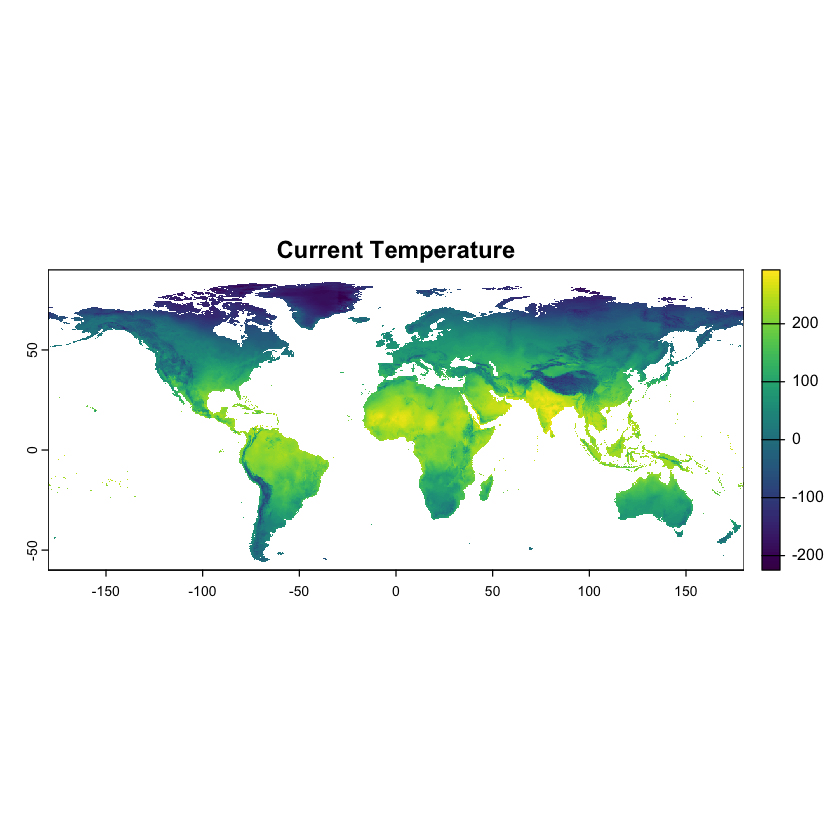

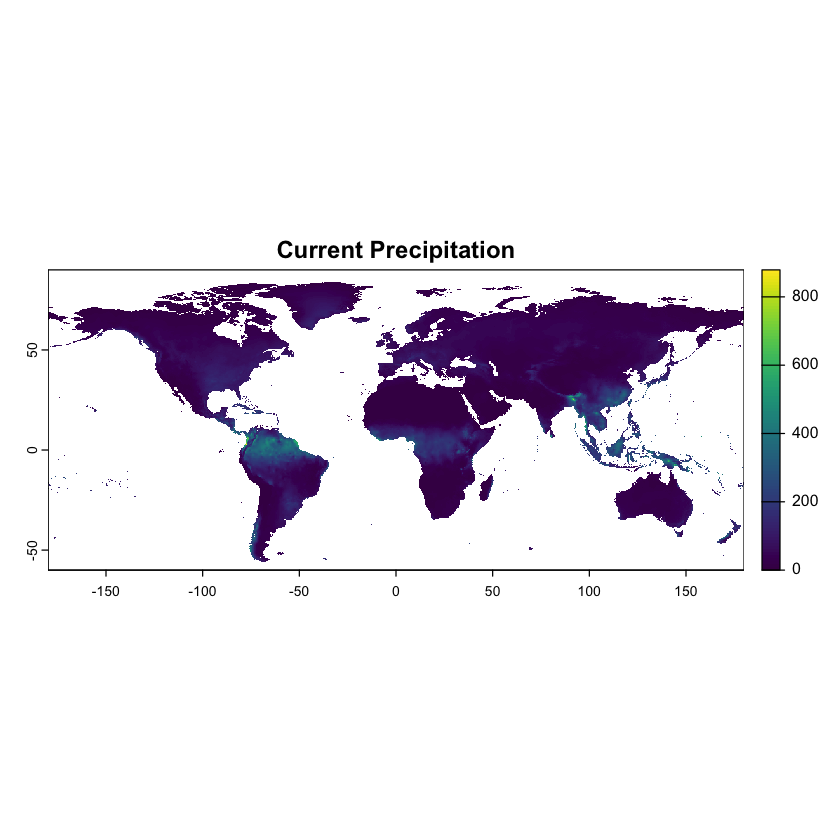

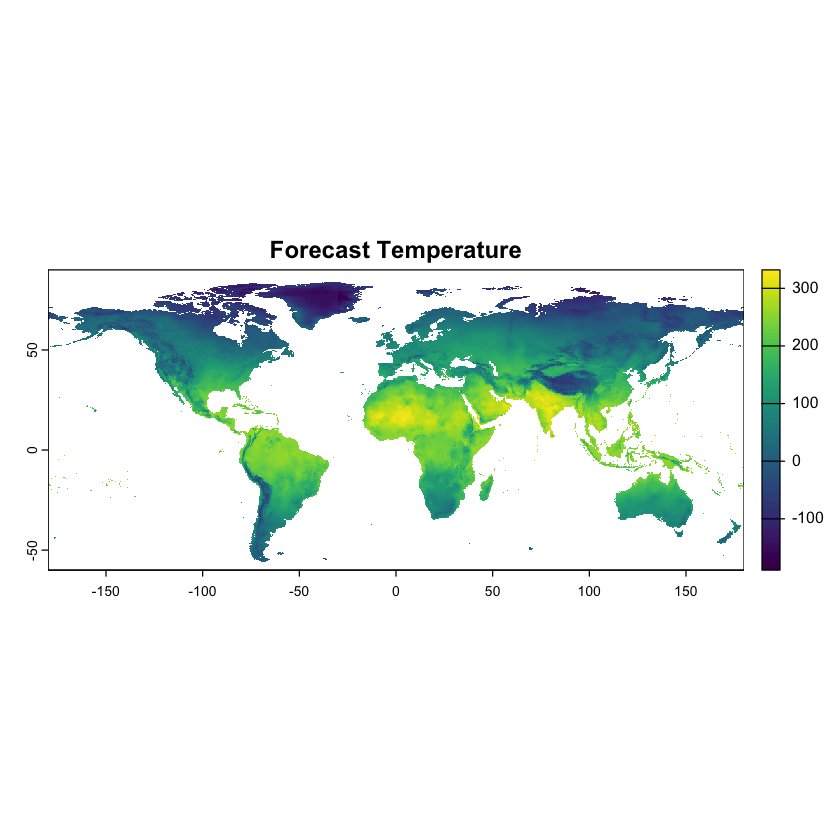

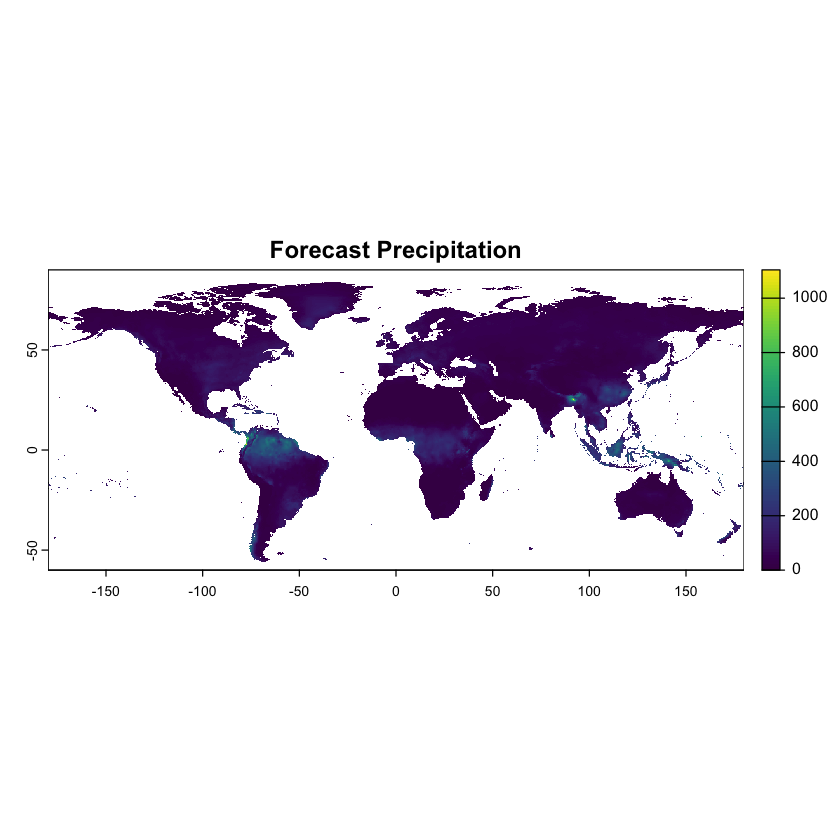

In [5]:
# Load environmental raster data
env_data_current <- rast(file.path(Workspace, "raw_data", "env_current.grd"))
env_data_forecast <- rast(file.path(Workspace, "raw_data", "env_forecast.grd"))

# Print summaries for the raster files
print(env_data_current)
print(env_data_forecast)

# Plot temperature and precipitation layers
plot(env_data_current$tmin, main = "Current Temperature")
plot(env_data_current$precip, main = "Current Precipitation")
plot(env_data_forecast$tmin, main = "Forecast Temperature")
plot(env_data_forecast$precip, main = "Forecast Precipitation")



## 4. Combine data for the model

In [6]:
# Extract raster values for tree kangaroo locations
tk_locations <- select(tree_kangaroo_data, lon, lat)

# Check if the extracted locations are valid
tk_env <- extract(env_data_current, tk_locations)

# Combine tree kangaroo data with extracted environmental data
tree_kangaroo_data <- cbind(tree_kangaroo_data, tk_env)

# Print out the first few rows of the updated data
head(tree_kangaroo_data)

# Check the structure and data types again
str(tree_kangaroo_data)

,species,lat,lon,present,ID,tmin,precip
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,NA,-17.27,145.48,1,1,140,75
2,NA,-16.92,145.77,1,2,188,142
3,NA,-17.29,145.57,0,3,148,134
4,NA,-17.38,145.67,1,4,151,205
5,NA,-17.38,145.67,1,5,151,205
6,NA,-17.35,145.59,0,6,142,138


'data.frame':	708 obs. of  7 variables:
 $ species: num  NA NA NA NA NA NA NA NA NA NA ...
 $ lat    : num  -17.3 -16.9 -17.3 -17.4 -17.4 ...
 $ lon    : num  145 146 146 146 146 ...
 $ present: int  1 1 0 1 1 0 1 1 1 1 ...
 $ ID     : num  1 2 3 4 5 6 7 8 9 10 ...
 $ tmin   : num  140 188 148 151 151 142 148 151 148 148 ...
 $ precip : num  75 142 134 205 205 138 134 205 134 134 ...


# 5. Plot or Visualise combined data

`geom_smooth()` using formula = 'y ~ x'


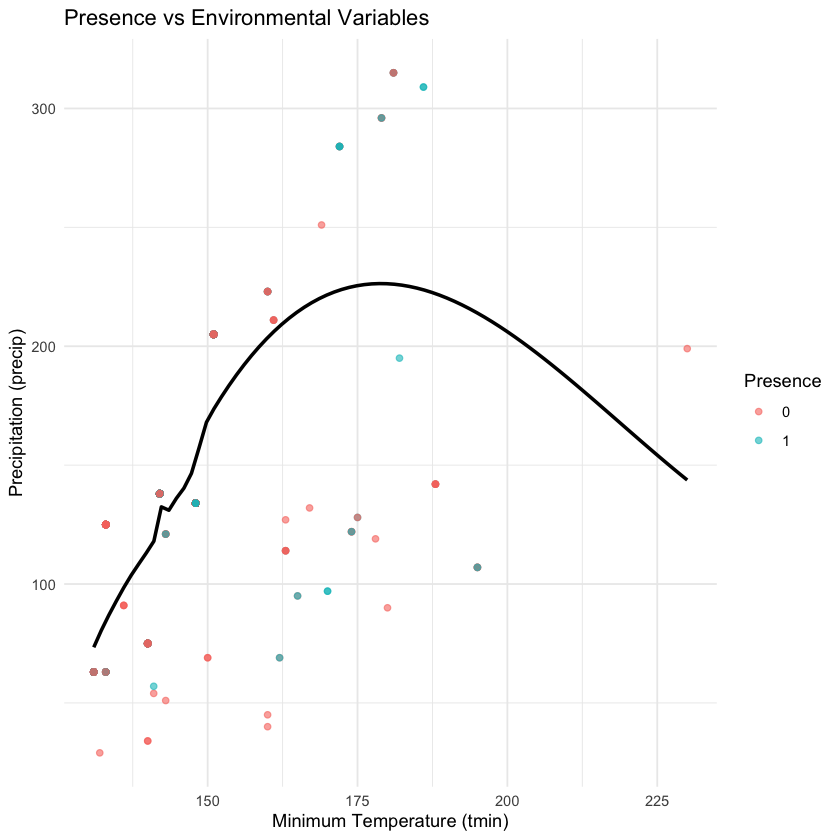

In [7]:
# Let us visualize the relationships between variables.
ggplot(tree_kangaroo_data, 
       mapping = aes(x = tmin, y = precip, color = factor(present))) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "loess", se = FALSE, color = "black") +
  labs(title = "Presence vs Environmental Variables",
       x = "Minimum Temperature (tmin)",
       y = "Precipitation (precip)",
       color = "Presence") +
  theme_minimal()

# C. Multivariate Logistic Regression (GLM)

## 1. Model Configuration

We are fitting a logistic regression model using tmin and precip as predictors. Additionally, we can add interaction terms to test for combined effects.

In [8]:
#Occurance on X & envir on Y
#Probability low or high for multiple variables

logistic_regr_model <- glm(present ~ tmin + precip,
                           family = binomial(link = "logit"),
                           data = tree_kangaroo_data)
summary(logistic_regr_model)


Call:
glm(formula = present ~ tmin + precip, family = binomial(link = "logit"), 
    data = tree_kangaroo_data)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept) -1.925655   1.099357  -1.752   0.0798 .
tmin         0.006446   0.008475   0.761   0.4469  
precip       0.001007   0.001951   0.516   0.6058  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 864.30  on 707  degrees of freedom
Residual deviance: 862.23  on 705  degrees of freedom
AIC: 868.23

Number of Fisher Scoring iterations: 4


In [9]:
str(env_data_forecast)
summary(env_data_forecast)
summary(env_data_current)
model_vars <- names(coef(logistic_regr_model))
missing_vars <- setdiff(model_vars, names(env_data_forecast))

if (length(missing_vars) > 0) {
  print(paste("Missing variables in env_data_forecast:", paste(missing_vars, collapse = ", ")))
}


S4 class 'SpatRaster' [package "terra"]


      tmin            precip       
 Min.   :-188.0   Min.   :   0.00  
 1st Qu.:  13.0   1st Qu.:  16.00  
 Median : 100.0   Median :  36.00  
 Mean   : 100.8   Mean   :  57.46  
 3rd Qu.: 200.0   3rd Qu.:  69.00  
 Max.   : 329.0   Max.   :1043.00  
 NA's   :70257    NA's   :70257    

      tmin             precip      
 Min.   :-224.00   Min.   :  0.00  
 1st Qu.: -19.00   1st Qu.: 14.00  
 Median :  73.00   Median : 34.00  
 Mean   :  68.13   Mean   : 57.26  
 3rd Qu.: 171.00   3rd Qu.: 67.00  
 Max.   : 292.00   Max.   :749.00  
 NA's   :70257     NA's   :70257   

[1] "Missing variables in env_data_forecast: (Intercept)"


## 2. Model evaluation

Evaluate the model performance using AUC and plot the ROC curve.

AUC: 0.5266519 


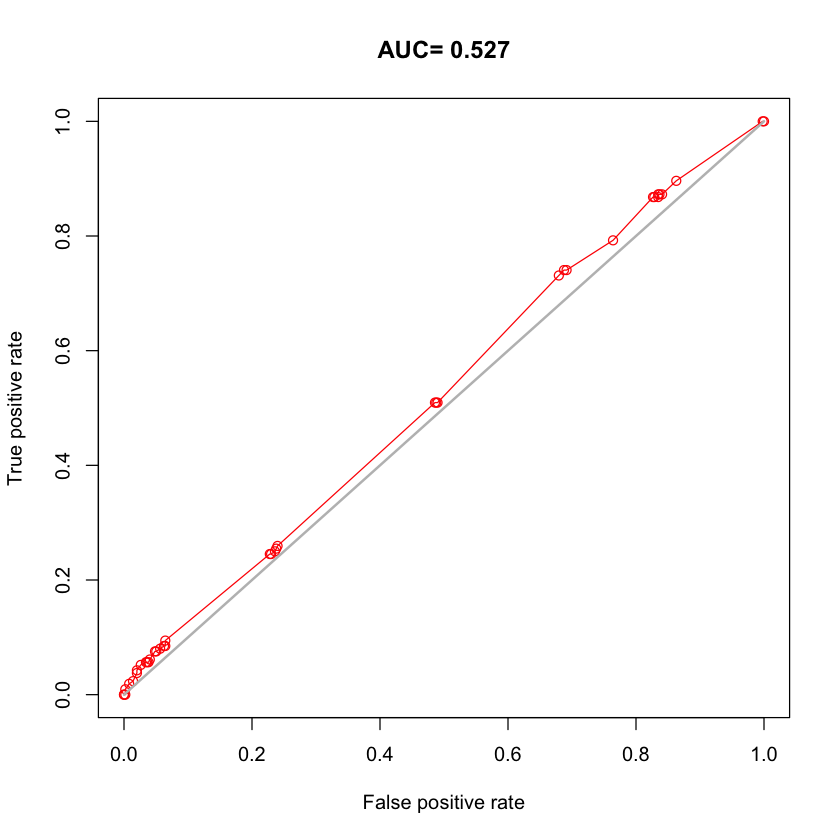

In [10]:
#assign presence and absences to respective data
presence_data <-filter(tree_kangaroo_data,present ==1)
absence_data <-filter(tree_kangaroo_data,present ==0)

# Evaluate the model
evaluation <- evaluate(presence_data, absence_data, logistic_regr_model)

# Plot ROC curve and calculate AUC
plot(evaluation, "ROC")
cat("AUC:", evaluation@auc, "\n")

# D. Predictions 
## 1. Predictions on Current Environment

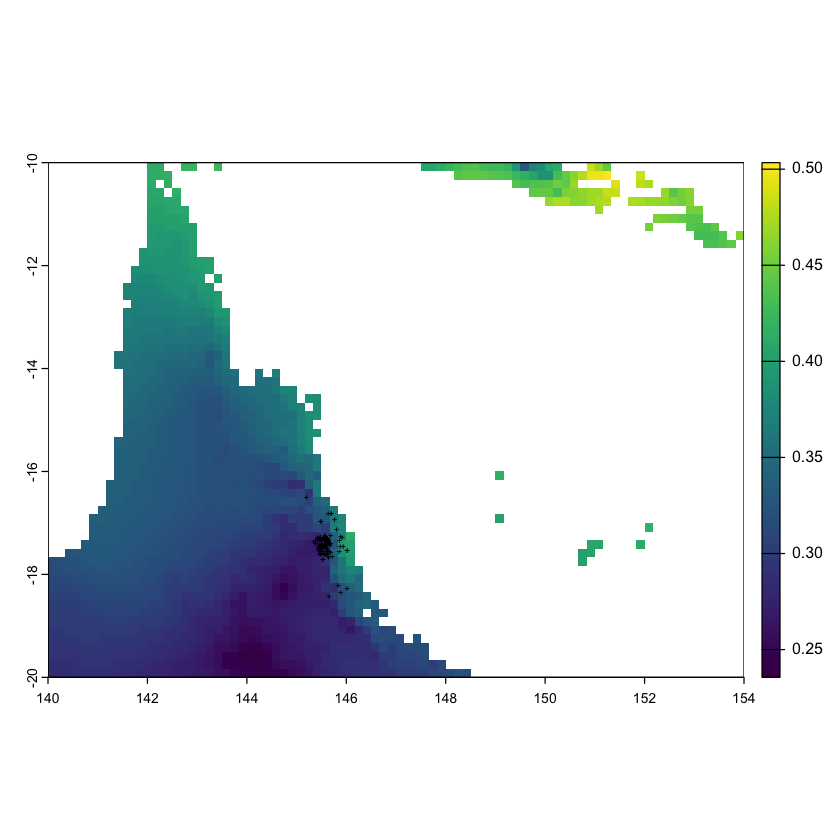

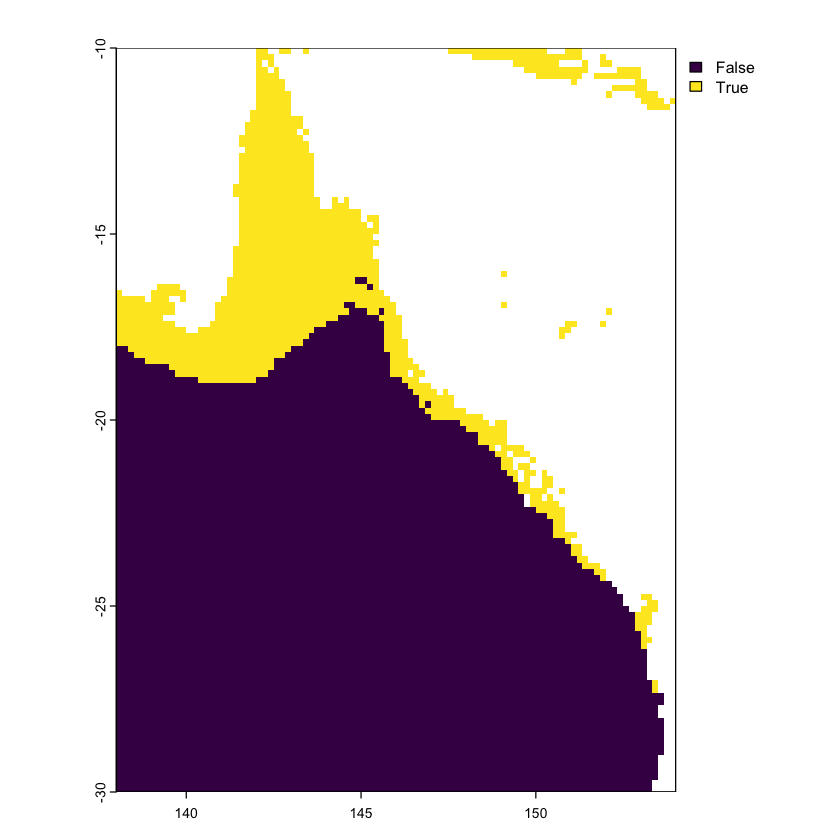

In [11]:
# for current environment
predictions <- predict(env_data_current, logistic_regr_model, type = "response")
plot(predictions, ext = extent(140, 154, -20, -10))
points(presence_data[c("lon", "lat")], pch = "+", cex = 0.5)

# Plot predictions with threshold
threshold <- threshold(evaluation, stat = "prevalence")
#40% threshold
plot(predictions>0.3, ext =extent(138, 154, -30, -10))


## 2. Predictions on Future Environment

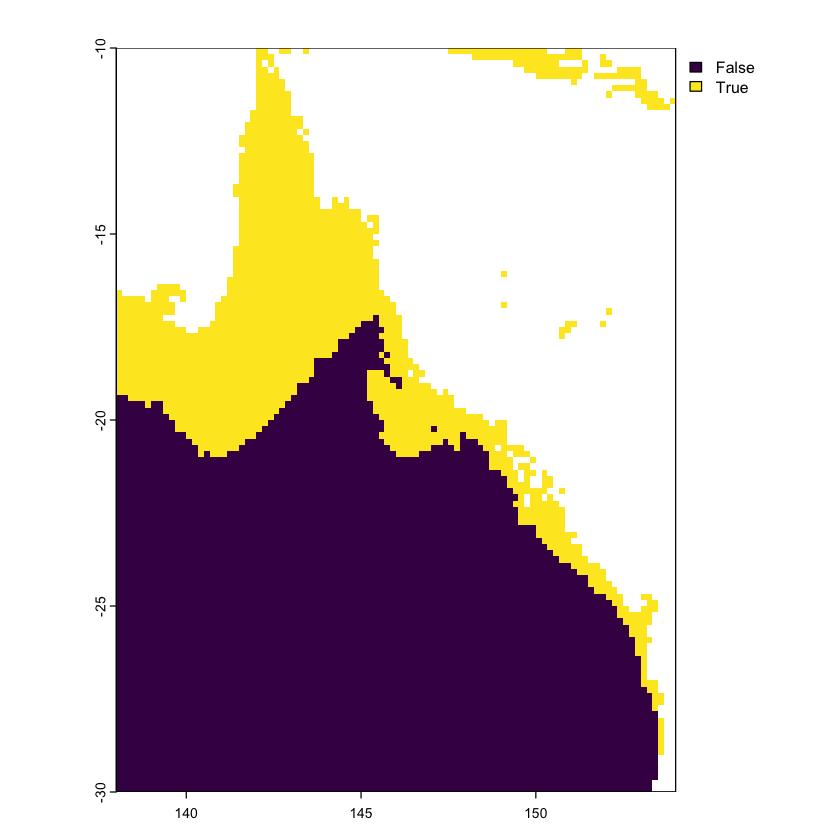

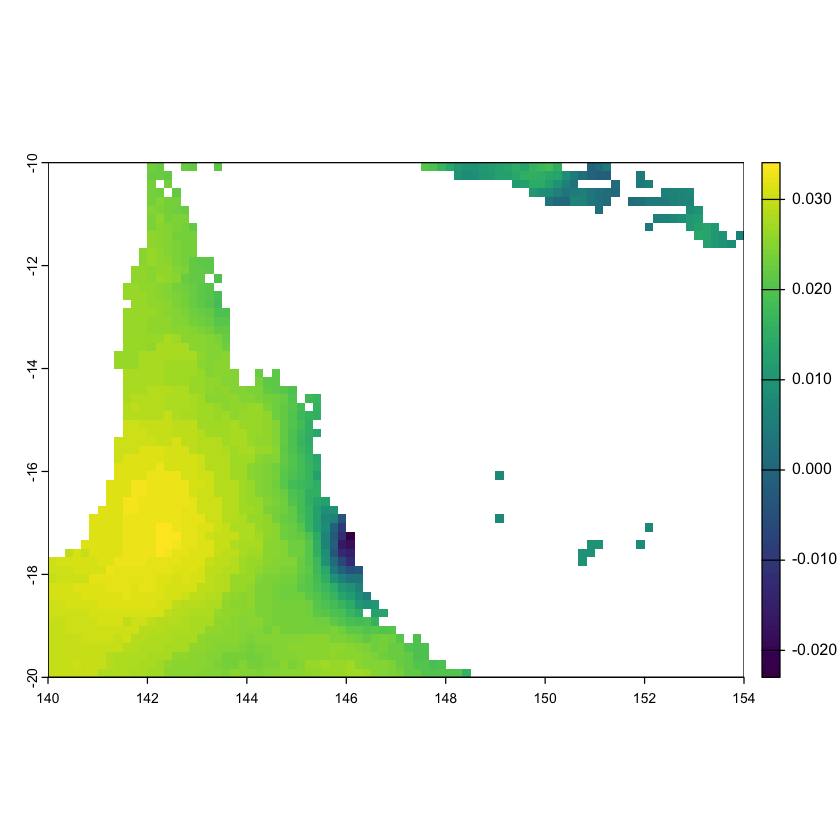

In [12]:
# same for future environment
forecasts <- predict(env_data_forecast, logistic_regr_model, type = "response")
plot(forecasts > 0.3, ext = extent(138, 154, -30, -10))

# Compare future and current predictions
plot(forecasts - predictions, ext = extent(140, 154, -20, -10))


## Outputs as HTML, R script, Log and PDF.

In [13]:
install.packages(c("knitr","rmarkdown","tinytex"))
tinytex::install_tinytex()  # Installs TinyTeX, a minimal LaTeX distribution
tinytex::reinstall_tinytex()  # Reinstalls TinyTeX in case it’s corrupted



The downloaded binary packages are in
	/var/folders/t0/9dty7yc10v91d98_j_6hqpj00000gn/T//RtmpnoJsah/downloaded_packages


Found '/usr/local/bin/tlmgr', which indicates a LaTeX distribution may have existed in the system.



ERROR: Error in tinytex::install_tinytex(): If you want to force installing TinyTeX anyway, use tinytex::install_tinytex(force = TRUE).


In [ ]:
# Load necessary libraries
library(knitr)
library(rmarkdown)

# Define the name of the notebook
notebook_name <- "EC_GLM_lite"

# Create the output folder
output_dir <- "output"
dir.create(output_dir, showWarnings = FALSE, recursive = TRUE)

# Convert notebook to RMarkdown (.Rmd) and save in the output folder
purl(paste0(notebook_name, ".ipynb"), output = file.path(output_dir, paste0(notebook_name, ".Rmd")))

# Knit the RMarkdown file to HTML and save in the output folder
render(file.path(output_dir, paste0(notebook_name, ".Rmd")), 
       output_format = "html_document", 
       output_dir = output_dir)

# Knit the RMarkdown file to PDF and save in the output folder
render(file.path(output_dir, paste0(notebook_name, ".Rmd")), 
       output_format = "pdf_document", 
       output_dir = output_dir)

# Export R script (.R) and save in the output folder
purl(paste0(notebook_name, ".ipynb"), output = file.path(output_dir, paste0(notebook_name, ".R")))



[1] "output/EC_GLM_lite.Rmd"



processing file: EC_GLM_lite.Rmd



1/1


output file: EC_GLM_lite.knit.md




/usr/local/bin/pandoc +RTS -K512m -RTS EC_GLM_lite.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1.GithubRepo/EC_notebook/notebooks/notebooks/species_distribution_models/output/EC_GLM_lite.html --lua-filter /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/library/rmarkdown/rmarkdown/lua/latex-div.lua --lua-filter /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/library/rmarkdown/rmarkdown/lua/table-classes.lua --embed-resources --standalone --variable bs3=TRUE --section-divs --template /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/library/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable theme=bootstrap --mathjax --variable 'mathjax-url=https://mathjax.rstudio.


Output created: output/EC_GLM_lite.html



processing file: EC_GLM_lite.Rmd



1/1


output file: EC_GLM_lite.knit.md




/usr/local/bin/pandoc +RTS -K512m -RTS EC_GLM_lite.knit.md --to latex --from markdown+autolink_bare_uris+tex_math_single_backslash --output /Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1.GithubRepo/EC_notebook/notebooks/notebooks/species_distribution_models/output/EC_GLM_lite.tex --lua-filter /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --highlight-style tango --pdf-engine pdflatex --variable graphics --variable 'geometry:margin=1in' 


! sh: pdflatex: command not found




ERROR: Error: LaTeX failed to compile /Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1.GithubRepo/EC_notebook/notebooks/notebooks/species_distribution_models/output/EC_GLM_lite.tex. See https://yihui.org/tinytex/r/#debugging for debugging tips. See EC_GLM_lite.log for more info.


In [ ]:
render(file.path(output_dir, paste0(notebook_name, ".Rmd")), 
       output_format = "pdf_document", 
       output_dir = output_dir)




processing file: EC_GLM_lite.Rmd



1/1


output file: EC_GLM_lite.knit.md




/usr/local/bin/pandoc +RTS -K512m -RTS EC_GLM_lite.knit.md --to latex --from markdown+autolink_bare_uris+tex_math_single_backslash --output /Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1.GithubRepo/EC_notebook/notebooks/notebooks/species_distribution_models/output/EC_GLM_lite.tex --lua-filter /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --highlight-style tango --pdf-engine pdflatex --variable graphics --variable 'geometry:margin=1in' 



Output created: output/EC_GLM_lite.pdf



In [ ]:
#Alternative 
render(file.path(output_dir, paste0(notebook_name, ".Rmd")), 
       output_format = "pdf_document", 
       output_options = list(latex_engine = "xelatex"))




processing file: EC_GLM_lite.Rmd



1/1


output file: EC_GLM_lite.knit.md




/usr/local/bin/pandoc +RTS -K512m -RTS EC_GLM_lite.knit.md --to latex --from markdown+autolink_bare_uris+tex_math_single_backslash --output EC_GLM_lite.tex --lua-filter /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --highlight-style tango --pdf-engine xelatex --variable graphics --variable 'geometry:margin=1in' 



Output created: EC_GLM_lite.pdf



## Model improvements


Cross-Validation: Apply cross-validation to assess model performance more robustly.

In [ ]:
# Install caret package if not already installed
install.packages("caret")

# Load caret package
library(caret)


In [ ]:

set.seed(42)
cv_model <- train(present ~ tmin + precip + tmin:precip,
                  data = tree_kangaroo_data,
                  method = "glm",
                  family = binomial,
                  trControl = trainControl(method = "cv", number = 5))
print(cv_model)


Regularization (Lasso/Ridge): To handle potential multicollinearity and enhance model generalization, try adding regularization.

In [ ]:
install.packages(glmnet)
library(glmnet)

In [ ]:

x <- model.matrix(present ~ tmin + precip + tmin:precip, tree_kangaroo_data)
y <- tree_kangaroo_data$present

lasso_model <- cv.glmnet(x, y, family = "binomial", alpha = 1)
plot(lasso_model)


Check for Collinearity: High multicollinearity can affect model performance. Use vif() to identify and address this issue.

In [ ]:
install.packages(car)

In [ ]:
library(car)
vif(logistic_regr_model)
